In [0]:
######## >>>>>>>>>>> For the google colab to be able to access the meta files you must add the APS360 team shared folder to your drive by right clicking on it <<<<<<<<<<< ##############
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Raw csv downloaded must be place in /raw folder
#Merged csv will be stored at /datasets folder
def make_csv_daily(station, start_year, end_year, out_name =  None):
  """
    Args:
        station (string): eg. "ON_6158355"
        start_year (int): Starting year
        end_year (int)  : Ending year
        start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
        out_name (optional string) : change the name of the output file
    """
  if out_name == None:
    out_name = station + '_' + str(start_year) + '-' + str(end_year)
  master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
  src_path = master_path + 'raw/'
  dest_path = master_path + 'datasets/'
  fout = open(dest_path + out_name + ".csv","w+")
  in_base = "en_climate_daily_" + station + '_' #eg: 'en_climate_daily_ON_6158355_'
  in_end = '_P1D.csv'
  # first file:
  for line in open(src_path + in_base + str(start_year) + in_end):
      fout.write(line)
  # now the rest:    
  for num in range(start_year + 1, end_year + 1):
      f = open(src_path + in_base + str(num) + in_end)
      f.__next__() # skip the header
      for line in f:
          fout.write(line)
      f.close() # not really needed
  fout.close()


In [0]:
####### run once #######
make_csv_daily("ON_6158355", 2007, 2016) # run once
make_csv_daily("ON_6158355", 2017, 2018) # run once

In [0]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
class WeatherDataset(Dataset):
    """Weather dataset."""

    def __init__(self, station, start_year, end_year, start_date = 0, end_date = None, num_days = 7, make_csv = False, out_name = None):
        """
        Args:
            station (string): eg. "ON_6158355"
            start_year (int): Starting year
            end_year (int)  : Ending year
            start_date (int): start_date = 0 is day 1 of starting year (Where we want the sampling to start)
            end_date (optional int) : end_date = 7 is day 8 of starting year(min = 7 because of LABEL!). If provided changes the end date from last day of last year.
            num_days (optional int) : num_days is the interval of days before the label.
            make_csv (optional bool): If true it will call make_csv_daily function to create the csv from /raw datasets into /datasets
            out_name (optional string) : change the name of the output file which it reads from
        """
        self.num_days = num_days
        if(out_name == None):
          self.out_name = station + '_' + str(start_year) + '-' + str(end_year)
        else:
          self.out_name = out_name
        master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
        dest_path = master_path + 'datasets/'
        if (make_csv):
          make_csv_daily(station, start_year, end_year, out_name =  out_name)

        self.cur_csv = pd.read_csv(dest_path + self.out_name +'.csv')

        self.start_date = start_date
        if( end_date == None):
          self.end_date = len(self.cur_csv) - start_date
        else:
          self.end_date = end_date

    def __len__(self):
        return self.end_date - self.start_date + 1 - self.num_days - 1

    def __getitem__(self, idx):
        data = self.cur_csv.loc[ idx + self.start_date : idx + self.start_date + self.num_days - 1 , ['Max Temp (°C)', 'Min Temp (°C)'] ]
        data = np.asarray(data)
        data = data.astype('float')

        label = self.cur_csv.loc[ idx + self.start_date + self.num_days, ['Max Temp (°C)', 'Min Temp (°C)'] ]
        label = np.asarray(label)
        label = label.astype('float')

        data = data.flatten()

        #print('Data: {}'.format(data))
        #print('Data shape: {}'.format(data.shape))
        #print('Labels shape: {}'.format(label.shape))
        #print('Labels: {}'.format(label[:2]))
        sample = [data, label]

        return sample

In [0]:
start_year_train = 2007
end_year_train = 2016 #changed from 2019 because in our proposal we said 07-16 is train
start_date_train = 0
end_date_train = 800
num_days_train = 7
station = "ON_6158355"
trainingSet = WeatherDataset(station, start_year_train, end_year_train, start_date_train, end_date_train, num_days=num_days_train, make_csv = False)

start_year_val = 2017
end_year_val = 2018
start_date_val = 0
end_date_val = 50
num_days_val = 7
# station stays the same
validationSet = WeatherDataset(station, start_year_val, end_year_val, start_date_val, end_date_val, num_days_val, make_csv = False)

In [0]:
trainingSet[2]

[array([ 8.1,  2.4, 10.1,  4.8, 11.9,  7.7, 10. ,  4.1,  4.8,  3.3,  5.4,
         0.5,  2.5, -3.7]), array([-1.9, -5.7])]

In [0]:
validationSet[2]

[array([  4.8,   2.4,   3.8,  -7.6,  -5.3, -10.3,  -5.9, -11.8,  -6.4,
        -11.8,  -8.2, -11.1,  -1.2,  -8.5]), array([ 7.1, -1.7])]

In [0]:
train_loader = torch.utils.data.DataLoader(trainingSet, batch_size=2, 
                                            num_workers=1, shuffle=True)
for i, data in enumerate(train_loader, 0):
  if(i == 1):
    break
  input, label = data
  print("input:")
  print(input)
  print("label:")
  print(label)

input:
tensor([[  5.4000,   0.5000,   2.5000,  -3.7000,  -1.9000,  -5.7000,   7.1000,
          -4.8000,   8.2000,   2.8000,   4.9000,  -2.2000,  -0.2000,  -2.1000],
        [  7.1000,  -4.8000,   8.2000,   2.8000,   4.9000,  -2.2000,  -0.2000,
          -2.1000,  -0.3000,  -5.3000,  -5.3000, -11.1000,  -2.1000, -10.3000]],
       dtype=torch.float64)
label:
tensor([[-0.3000, -5.3000],
        [ 1.8000, -2.5000]], dtype=torch.float64)


# ANN TRAINING

In [0]:
import os 
from torch.utils.data.sampler import SubsetRandomSampler 
from torchvision import datasets, models, transforms 
import torch.optim as optim
import numpy as np 
import matplotlib.pyplot as plt
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim 
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms 
use_cuda = True

#we prolly need cuda? to speed things up?

### Helper functions

In [0]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [0]:
# not sure if this is needed

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

In [0]:
# might want to change this to accuracy hhmmmMMMMMmmm
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_acc.csv".format(path))
    val_err = np.loadtxt("{}_val_acc.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Visualization of data

In [0]:
# laterrrrrrr

### Architecture

In [0]:
# input size: 14 (the highs and hows for the past 7 days)
# output size: 2 (the highs and lows for the next day)
# batch size is 2

# gonna go with a multilayer ann?
# online: cnns good for image and audio, prolly not for text
# either case we know that a recurrant is prolly the best for this


In [0]:
class ann(nn.Module):
  def __init__(self):
    super(ann, self).__init__()
    self.name = "weatherANN"
    self.layer1 = nn.Linear(14, 50) #input tensor size 14
    self.layer2 = nn.Linear(50, 2) #output tensor size 2
  def forward(self, x):
    #flattened = x.reshape(-1, 14) # ERROR
    activation1 = self.layer1(x)
    activation1 = F.relu(activation1)
    activation2 = self.layer2(activation1) 
    return activation2

### Training

In [0]:
def get_accuracy(net, loader, criterion):
    total_loss = 0.0
    total_err = 0.0
    number_items = 0
    for i, data in enumerate(loader, 0):
      #print("Evaluating", i+1, "out of", len(loader))
      inputs, labels = data
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
      #############################################
      outputs = net(inputs.float())
      loss = criterion(outputs, labels.float()) # Soft max is required for multi class as the final activation function to produce probability for each different class. If not used cirterion should be cross entropey loss else NLLLoss(negative loss likelyhood)
      for j, out in enumerate(outputs, 0):
          total_err += abs(labels[j][0] - out[0])
          total_err += abs(labels[j][1] - out[1])
      total_loss += loss.item()
      number_items += 2 * len(labels)
    err = float(total_err) / number_items
    loss = float(total_loss) / (i + 1)
    return err, loss

In [0]:
# what are we using as the validation loader
# regression midek: should use MSE (?)
def train(net, trainingSet, validationSet, batch_size=30, num_epochs=10, learning_rate=0.01, doPrint = False, plot = True):
    torch.manual_seed(777)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_loader = torch.utils.data.DataLoader(trainingSet, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validationSet, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)

    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    iters = []
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    print ("Training Started...")
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        if(doPrint):
          print("Epoch:", epoch+1)
        iters.append(epoch)
        total_train_loss = 0.0
        total_train_err = 0.0
        number_items = 0
        for i, data in enumerate(train_loader, 0): # Itterate through each batch
            #print("Training", i, "out of", len(train_loader))
            # Get the inputs
            inputs, labels = data
            #print("input:")
            #print(inputs)
            #print("label:")
            #print(labels)
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            outputs = net(inputs.float())             # forward pass
            loss = criterion(outputs, labels.float()) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Calculate the statistics
            for j, out in enumerate(outputs, 0):
                total_train_err += abs(labels[j][0] - out[0])
                total_train_err += abs(labels[j][1] - out[1]) 
            total_train_loss += loss.item()
            number_items += 2 * len(labels) 

        train_err[epoch] = float(total_train_err) / number_items
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = get_accuracy(net, val_loader, criterion)
        if(doPrint):
          print(("Epoch {}: Train err: {}, Train loss: {} |"+
                  "Validation err: {}, Validation loss: {}").format(
                      epoch + 1,
                      train_err[epoch],
                      train_loss[epoch],
                      val_err[epoch],
                      val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        #model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
        #model_path = "APS360/" + net.name + model_path
        #torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/err into CSV file for plotting later
    """
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    """
    if(plot):
      # plotting
      plt.title("Loss Curve")
      plt.plot(iters, train_loss, label="Train")
      plt.plot(iters, val_loss, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.show()

      plt.title("Error Curve")
      plt.plot(iters, train_err, label="Train")
      plt.plot(iters, val_err, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Error")
      plt.legend(loc='best')
      plt.show()


In [0]:
# we dont have a val_loader yet? maybe misunderstanding how we are going ot be validating it >:D

Finished Training
Total time elapsed: 17.97 seconds


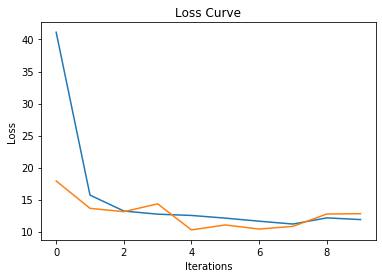

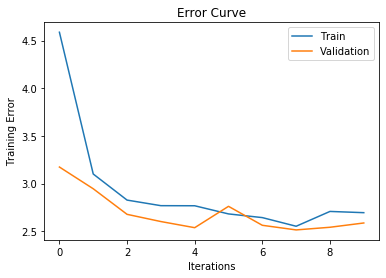

In [0]:
weather_ann = ann()
train(weather_ann.cuda(), trainingSet=trainingSet, validationSet=validationSet)

### Tuning

best model???



# Graveyard of codes

c######################################################################
c######################################################################
a##########OOOOOOO#####################################OOOOOOO##########
a##########OOOOOOO#####################################OOOOOOO##########
a##########OOOOOOO#####################################OOOOOOO##########
a##########OOOOOOO#####################################OOOOOOO##########
c#######################################################################
c###############################^^^^^^^^^^^^^^##############################
c################################^^^^^^^^^^^###############################
c#################################^^^^^^^^^##############################













In [0]:
import pandas as pd
import numpy as np

start_date = 0
num_days = 7
station = "ON_6158355"
out_name = station + '_' + str(start_year) + '-' + str(end_year)
master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
dest_path = master_path + 'datasets/'
landmarks_frame = pd.read_csv(dest_path + out_name +'.csv')

n = 65
img_name = landmarks_frame.iloc[ start_date : start_date + num_days, [9, 11] ]
img_name = np.asarray(img_name)
landmarks = landmarks_frame.iloc[ start_date + num_days + 1, [9, 11] ]
landmarks = np.asarray(landmarks)
#landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:2]))

Image name: [[10.1  2.6]
 [ 6.4  0.7]
 [ 8.1  2.4]
 [10.1  4.8]
 [11.9  7.7]
 [10.   4.1]
 [ 4.8  3.3]]
Landmarks shape: (2,)
First 4 Landmarks: [2.5 -3.7]


In [0]:
len(landmarks_frame)

4748

In [0]:
import pandas as pd
import numpy as np
start_year = 2007
end_year = 2019
start_date = 0
num_days = 7
station = "ON_6158355"
out_name = station + '_' + str(start_year) + '-' + str(end_year)
master_path = '/content/gdrive/My Drive/APS360 Team/milestone 1/'
dest_path = master_path + 'datasets/'
cur_csv = pd.read_csv(dest_path + out_name +'.csv')

n = 65
data = cur_csv.loc[ :6 , ['Max Temp (°C)', 'Min Temp (°C)'] ]
data = np.asarray(data)
data = data.astype('float')
label = cur_csv.loc[ 6, ['Max Temp (°C)', 'Min Temp (°C)'] ]
label = np.asarray(label)
label = label.astype('float')

data = data.flatten()
#data = np.expand_dims(data, axis=0)
#data = data.reshape((2,7))
label = np.asarray(label)
data = np.asarray(data)

print('Image name: {}'.format(data))
print('Image shape: {}'.format(data.shape))
print('Landmarks shape: {}'.format(label.shape))
print('First 4 Landmarks: {}'.format(label[:2]))

sample = [data, label]
sample

Image name: [10.1  2.6  6.4  0.7  8.1  2.4 10.1  4.8 11.9  7.7 10.   4.1  4.8  3.3]
Image shape: (14,)
Landmarks shape: (2,)
First 4 Landmarks: [4.8 3.3]


[array([10.1,  2.6,  6.4,  0.7,  8.1,  2.4, 10.1,  4.8, 11.9,  7.7, 10. ,
         4.1,  4.8,  3.3]), array([4.8, 3.3])]

Training Started...
Finished Training
Total time elapsed: 17.88 seconds


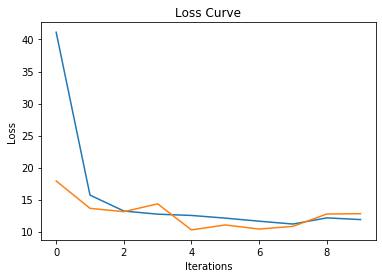

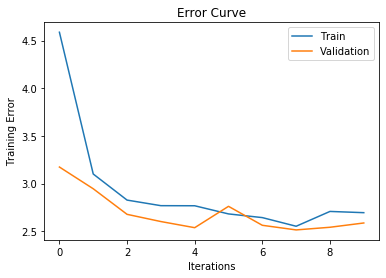

In [0]:
start_year_train = 2007
end_year_train = 2016 #changed from 2019 because in our proposal we said 07-16 is train
start_date_train = 0
end_date_train = 800
num_days_train = 7
station = "ON_6158355"
trainingSet = WeatherDataset(station, start_year_train, end_year_train, start_date_train, end_date_train, num_days=num_days_train, make_csv = False)

start_year_val = 2017
end_year_val = 2018
start_date_val = 0
end_date_val = 50
num_days_val = 7
# station stays the same
validationSet = WeatherDataset(station, start_year_val, end_year_val, start_date_val, end_date_val, num_days_val, make_csv = False)

weather_ann = ann()
net = weather_ann.cuda()
batch_size= 30
num_epochs= 10 
learning_rate=0.01
doPrint = False
plot = True

torch.manual_seed(777)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(trainingSet, batch_size=batch_size, 
                                        num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(validationSet, batch_size=batch_size, 
                                        num_workers=1, shuffle=True)

# Set up some numpy arrays to store the training/test loss/erruracy
train_err = np.zeros(num_epochs)
train_loss = np.zeros(num_epochs)
val_err = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
iters = []
########################################################################
# Train the network
# Loop over the data iterator and sample a new batch of training data
# Get the output from the network, and optimize our loss function.
start_time = time.time()
print ("Training Started...")
for epoch in range(num_epochs):  # loop over the dataset multiple times
    if(doPrint):
      print("Epoch:", epoch+1)
    iters.append(epoch)
    total_train_loss = 0.0
    total_train_err = 0.0
    number_items = 0
    for i, data in enumerate(train_loader, 0): # Itterate through each batch
        #print("Training", i, "out of", len(train_loader))
        # Get the inputs
        inputs, labels = data
        #print("input:")
        #print(inputs)
        #print("label:")
        #print(labels)
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()
        #############################################
        
          
        outputs = net(inputs.float())             # forward pass
        loss = criterion(outputs, labels.float()) # compute the total loss
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # a clean up step for PyTorch

        # Calculate the statistics
        for j, out in enumerate(outputs, 0):
            total_train_err += abs(labels[j][0] - out[0])
            total_train_err += abs(labels[j][1] - out[1]) 
        total_train_loss += loss.item()
        number_items += 2 * len(labels) 

    train_err[epoch] = float(total_train_err) / number_items
    train_loss[epoch] = float(total_train_loss) / (i+1)
    val_err[epoch], val_loss[epoch] = get_accuracy(net, val_loader, criterion)
    if(doPrint):
      print(("Epoch {}: Train err: {}, Train loss: {} |"+
              "Validation err: {}, Validation loss: {}").format(
                  epoch + 1,
                  train_err[epoch],
                  train_loss[epoch],
                  val_err[epoch],
                  val_loss[epoch]))
    # Save the current model (checkpoint) to a file
    #model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
    #model_path = "APS360/" + net.name + model_path
    #torch.save(net.state_dict(), model_path)
print('Finished Training')
end_time = time.time()
elapsed_time = end_time - start_time
print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

# Write the train/test loss/err into CSV file for plotting later
"""
epochs = np.arange(1, num_epochs + 1)
np.savetxt("{}_train_err.csv".format(model_path), train_err)
np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
np.savetxt("{}_val_err.csv".format(model_path), val_err)
np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
"""
if(plot):
  # plotting
  plt.title("Loss Curve")
  plt.plot(iters, train_loss, label="Train")
  plt.plot(iters, val_loss, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Error Curve")
  plt.plot(iters, train_err, label="Train")
  plt.plot(iters, val_err, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Error")
  plt.legend(loc='best')
  plt.show()

